In [1]:
import json
from pathlib import Path
from datetime import datetime, timedelta, timezone

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from timesignal import EventSignal, EventSignalOrchestra

In [2]:
log_json_dir = Path('log_json')

log_json_files = list(log_json_dir.glob('lcmlog*.json'))

len(log_json_files)

32

In [3]:
def load_json(p: Path):
    with p.open('r') as f:
        return json.load(f)

In [4]:
TARGET_CHANNEL = 'MWT_SEARCH_STAT'
SUPERVISOR_CHANNEL = 'SUPERVISOR_CFG'
target_events = []
supervisor_events = []

for log_json_file in log_json_files:
    log_events = load_json(log_json_file)
    print('Parsed', log_json_file)

    target_events.extend(filter(lambda ev: ev['meta']['channel'] == TARGET_CHANNEL, log_events))
    supervisor_events.extend(filter(lambda ev: ev['meta']['channel'] == SUPERVISOR_CHANNEL, log_events))

print(len(target_events), 'total target events')
print(len(supervisor_events), 'total supervisor events')

Parsed log_json\lcmlog-2021-05-24.00.json
Parsed log_json\lcmlog-2021-05-24.01.json
Parsed log_json\lcmlog-2021-05-24.02.json
Parsed log_json\lcmlog-2021-05-24.03.json
Parsed log_json\lcmlog-2021-05-24.04.json
Parsed log_json\lcmlog-2021-05-24.05.json
Parsed log_json\lcmlog-2021-05-24.06.json
Parsed log_json\lcmlog-2021-05-24.07.json
Parsed log_json\lcmlog-2021-05-24.08.json
Parsed log_json\lcmlog-2021-05-24.09.json
Parsed log_json\lcmlog-2021-05-24.10.json
Parsed log_json\lcmlog-2021-05-24.11.json
Parsed log_json\lcmlog-2021-05-24.12.json
Parsed log_json\lcmlog-2021-05-24.13.json
Parsed log_json\lcmlog-2021-05-24.14.json
Parsed log_json\lcmlog-2021-05-24.15.json
Parsed log_json\lcmlog-2021-05-24.16.json
Parsed log_json\lcmlog-2021-05-24.17.json
Parsed log_json\lcmlog-2021-05-24.18.json
Parsed log_json\lcmlog-2021-05-25.00.json
Parsed log_json\lcmlog-2021-05-25.01.json
Parsed log_json\lcmlog-2021-05-25.02.json
Parsed log_json\lcmlog-2021-05-25.03.json
Parsed log_json\lcmlog-2021-05-25.

In [5]:
tz = timezone(timedelta(hours=-8))

def get_fields(ev: dict) -> tuple:
    utc_dt = datetime.fromtimestamp(ev['meta']['timestamp'] / 1e6, tz=tz).astimezone(tz=timezone.utc)
    
    d = ev['event']
    
    return utc_dt, d['x_effort_cmd'], d['z_set_point']

In [9]:
df = pd.DataFrame(map(get_fields, target_events), columns=('utc_dt', 'x_effort_cmd', 'z_set_point'))

df.head()

utc_dt  x_effort_cmd  z_set_point
0 2021-05-24 15:21:04.410289+00:00           0.0          0.0
1 2021-05-24 15:21:04.510703+00:00           0.0          0.0
2 2021-05-24 15:21:04.610265+00:00           0.0          0.0
3 2021-05-24 15:21:04.710716+00:00           0.0          0.0
4 2021-05-24 15:21:04.810397+00:00           0.0          0.0

DataFrame stride: 1000
Number of rows after stride: 4160


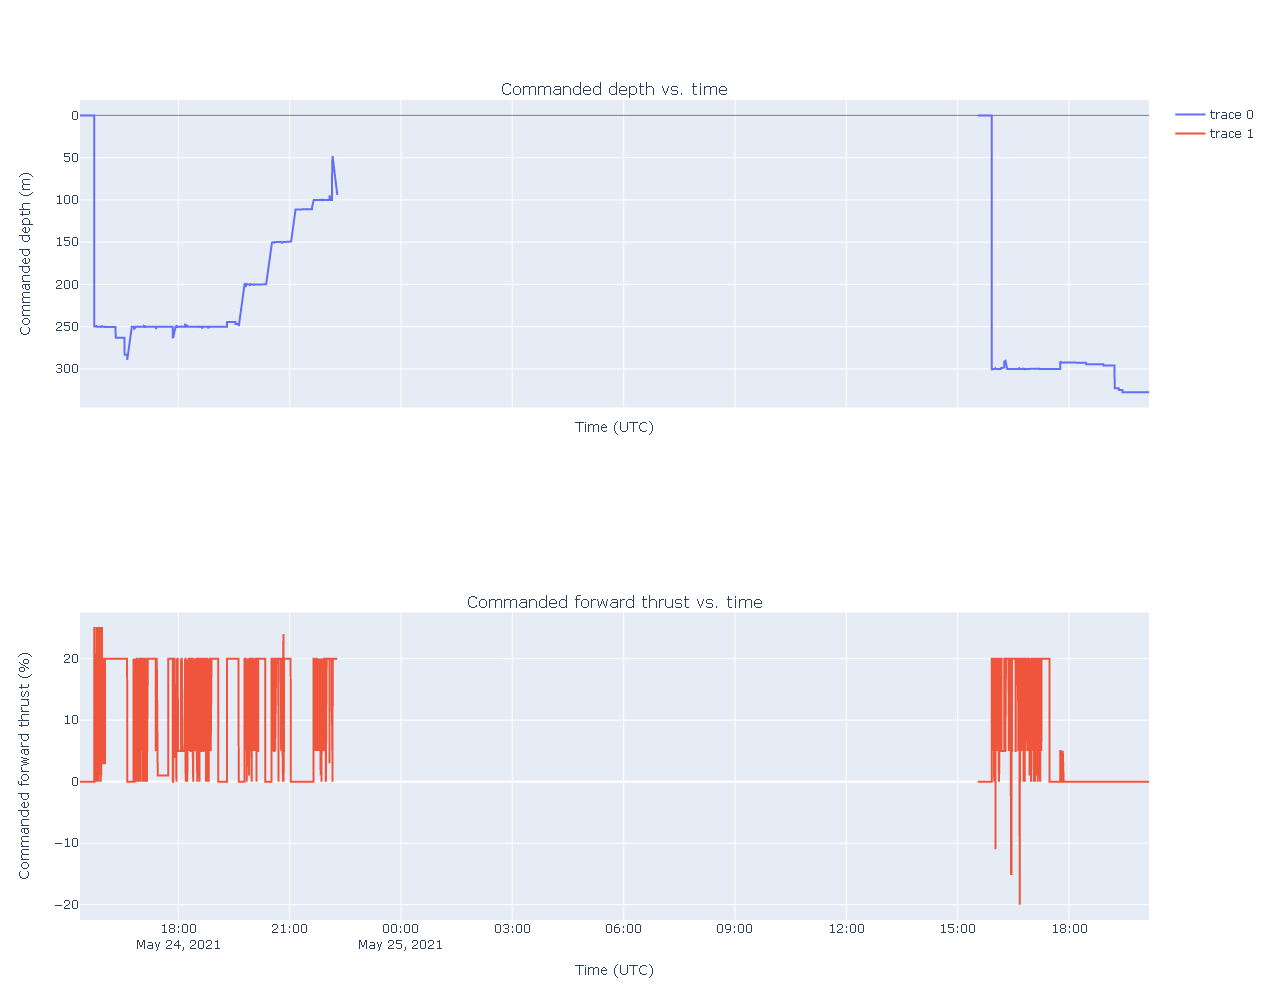

In [44]:
DF_STRIDE = 1000
strided_df = df.iloc[::100, :]
print('DataFrame stride:', DF_STRIDE)
print('Number of rows after stride:', len(strided_df))

# Find largest diff between UTC datetimes. This indicates the separation betwen the days
diff_series = strided_df['utc_dt'].diff()
largest_diff_idx = diff_series.idxmax()
strided_df.loc[largest_diff_idx, ('x_effort_cmd', 'z_set_point')] = None

stacked_fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=('Commanded depth vs. time', 'Commanded forward thrust vs. time'))

depth_trace = go.Scatter(x=strided_df['utc_dt'], y=strided_df['z_set_point'])
stacked_fig.add_trace(depth_trace, row=1, col=1)
stacked_fig.layout.yaxis.autorange = 'reversed'
stacked_fig.layout.yaxis.title = 'Commanded depth (m)'

thrust_trace = go.Scatter(x=strided_df['utc_dt'], y=strided_df['x_effort_cmd'])
stacked_fig.add_trace(thrust_trace, row=2, col=1)
stacked_fig.layout.yaxis2.title = 'Commanded forward thrust (%)'

stacked_fig.layout.xaxis.title = 'Time (UTC)'
stacked_fig.layout.xaxis2.title = 'Time (UTC)'

stacked_fig.update_layout(height=1000)

stacked_fig.layout.yaxis.zeroline = True
stacked_fig.layout.yaxis.zerolinewidth = 1
stacked_fig.layout.yaxis.zerolinecolor = 'gray'

stacked_fig.show()

## Discovery mode intervals, May 24

In [49]:
discovery_250_m_bounds_utc = ('2021-05-24T16:47:24+00:00', '2021-05-24T17:05:21+00:00')
discovery_200_m_bounds_utc = ('2021-05-24T19:47:03+00:00', '2021-05-24T20:06:43+00:00')
discovery_150_m_bounds_utc = ('2021-05-24T20:33:49+00:00', '2021-05-24T20:51:11+00:00')
discovery_100_m_bounds_utc = ('2021-05-24T21:38:24+00:00', '2021-05-24T21:59:35+00:00')

discovery_250_m_bounds_utc_dt = [datetime.fromisoformat(v) for v in discovery_250_m_bounds_utc]
discovery_200_m_bounds_utc_dt = [datetime.fromisoformat(v) for v in discovery_200_m_bounds_utc]
discovery_150_m_bounds_utc_dt = [datetime.fromisoformat(v) for v in discovery_150_m_bounds_utc]
discovery_100_m_bounds_utc_dt = [datetime.fromisoformat(v) for v in discovery_100_m_bounds_utc]

In [50]:
bounds_names = ['Discovery @ 250 m', 'Discovery @ 200 m', 'Discovery @ 150 m', 'Discovery @ 100 m']
bounds_items = [discovery_250_m_bounds_utc_dt, discovery_200_m_bounds_utc_dt, discovery_150_m_bounds_utc_dt, discovery_100_m_bounds_utc_dt]

In [53]:
def detect_stop_indices(vals: list, coast_val: float = 20.0, eps: float = 1e-2, min_coast_events: int = 10) -> list:
    n_coast_events = 0
    stop_indices = []
    for idx, val in enumerate(vals):
        coast = abs(val - coast_val) < eps
        
        if coast:
            n_coast_events += 1
        elif not coast and n_coast_events >= min_coast_events:
            # Stop detected
            stop_indices.append(idx)
            n_coast_events = 0
    
    return stop_indices

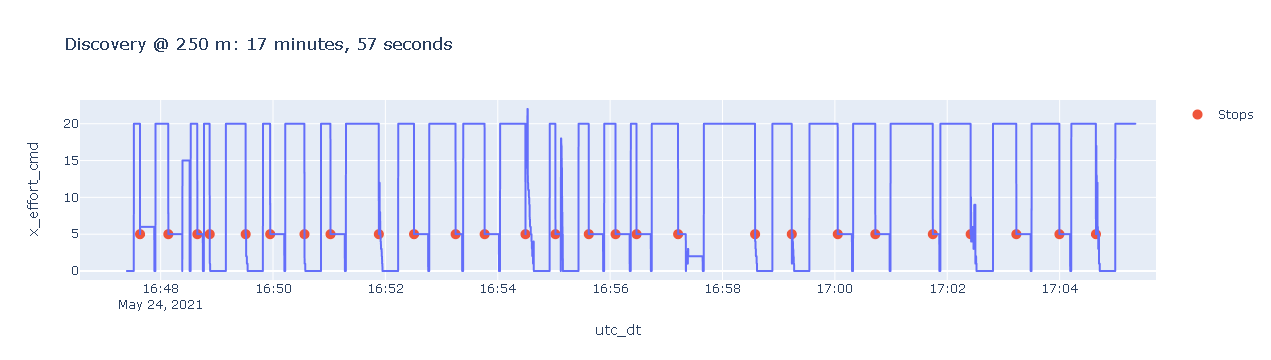

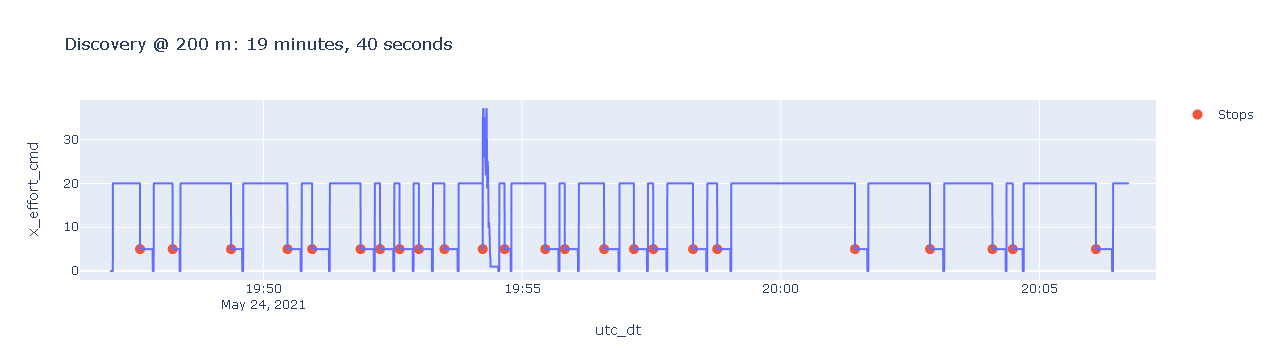

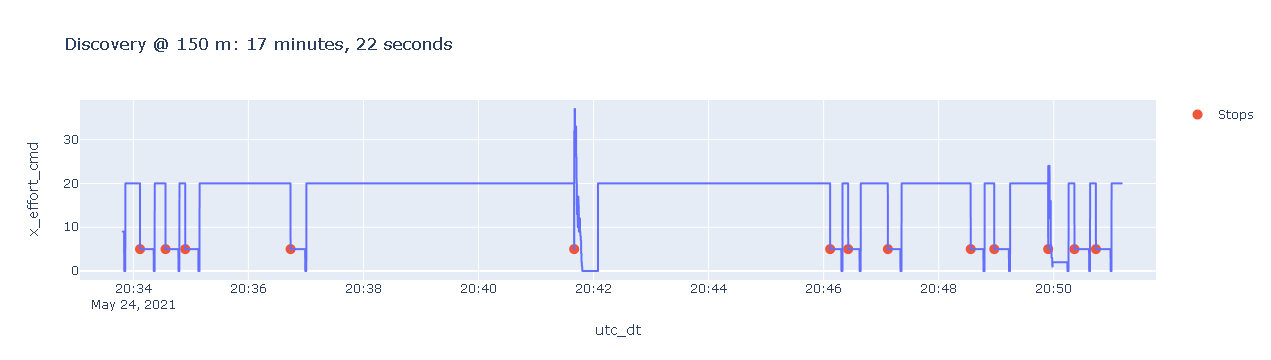

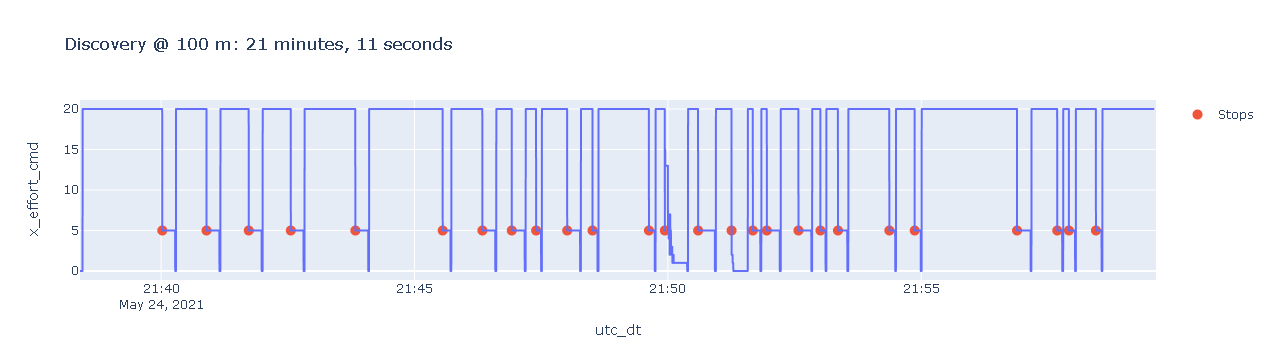

In [66]:
for bounds_name, bounds_item in zip(bounds_names, bounds_items):
    start_utc_dt, end_utc_dt = bounds_item
    duration_seconds = (end_utc_dt - start_utc_dt).total_seconds()
    mins, secs = divmod(duration_seconds, 60)
    
    df_part = df.loc[(df['utc_dt'] <= end_utc_dt) & (df['utc_dt'] >= start_utc_dt)]
    
    part_stop_indices = detect_stop_indices(df_part['x_effort_cmd'].tolist())
    part_stop_utc_dts = df_part['utc_dt'].iloc[part_stop_indices]
    part_stop_x_effort_cmds = df_part['x_effort_cmd'].iloc[part_stop_indices]
    
    fig_part = px.line(df_part, x='utc_dt', y='x_effort_cmd', title=f'{bounds_name}: {int(mins)} minutes, {round(secs)} seconds')
    fig_part.add_trace(go.Scatter(x=part_stop_utc_dts, y=part_stop_x_effort_cmds, mode='markers', name='Stops', marker_size=10))
    fig_part.show()

In [7]:
tz = timezone(timedelta(hours=-8))

def get_supervisor_fields(ev: dict) -> tuple:
    utc_dt = datetime.fromtimestamp(ev['meta']['timestamp'] / 1e6, tz=tz).astimezone(tz=timezone.utc)
    
    d = ev['event']
    
    return utc_dt, d['state_name'], d['control_mode']

supervisor_fields = [get_supervisor_fields(ev) for ev in supervisor_events]

In [11]:
supervisor_datetimes = [f[0] for f in supervisor_fields]
supervisor_state_ints = [{'search': 0, 'track': 1}[f[1]] for f in supervisor_fields]

In [12]:
signal = EventSignal(values=zip(supervisor_datetimes, supervisor_state_ints), interpolation='nearest')

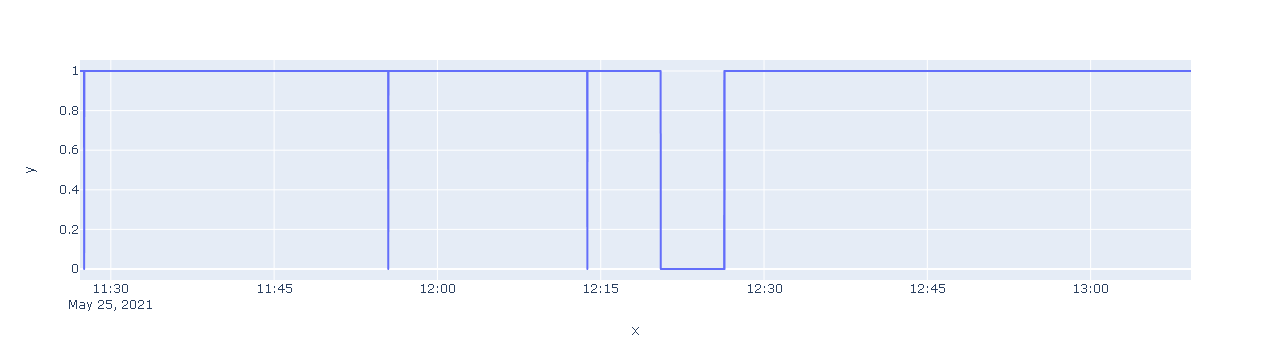

In [29]:
N = 100
sl = signal.duration / N

times, points = zip(*signal.values)

fig = px.line(x=times, y=points)
fig.show()